# 0.Load data from netCDF file

In [2]:
import xarray as xr
import matplotlib.pyplot as plt
%matplotlib inline

/Users/hugoshih/anaconda3/lib/python3.7/site-packages/dask/config.py:168: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  data = yaml.load(f.read()) or {}
/Users/hugoshih/anaconda3/lib/python3.7/site-packages/distributed/config.py:20: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  defaults = yaml.load(f)


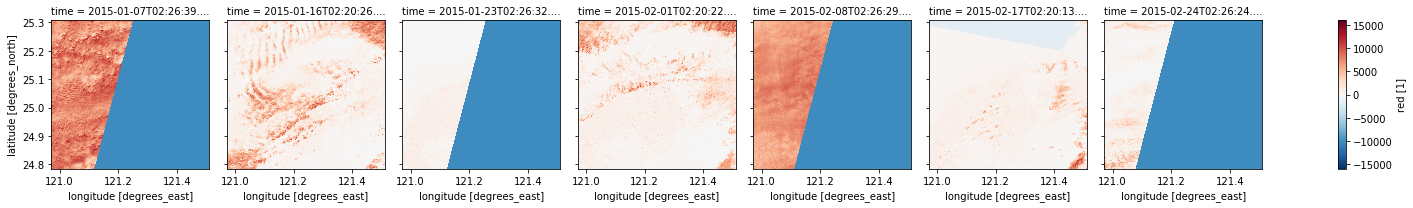

In [6]:
import os
path = os.path.abspath('.') 
dataset = xr.open_dataset(path + '/test.nc')
dataset.red.plot(col = 'time')

In [7]:
dataset

<xarray.Dataset>
Dimensions:    (latitude: 1942, longitude: 2001, time: 7)
Coordinates:
  * time       (time) datetime64[ns] 2015-01-07T02:26:39.138373 ... 2015-02-24T02:26:24.238678
  * latitude   (latitude) float64 25.31 25.31 25.31 25.31 ... 24.78 24.78 24.78
  * longitude  (longitude) float64 121.0 121.0 121.0 121.0 ... 121.5 121.5 121.5
Data variables:
    red        (time, latitude, longitude) int16 ...
    green      (time, latitude, longitude) int16 ...
    blue       (time, latitude, longitude) int16 ...
    nir        (time, latitude, longitude) int16 ...
    swir1      (time, latitude, longitude) int16 ...
    swir2      (time, latitude, longitude) int16 ...
    pixel_qa   (time, latitude, longitude) uint16 ...
Attributes:
    crs:      EPSG:4326

In [13]:
import numpy as np
import os

from osgeo import gdal
from sklearn import metrics
from sklearn.ensemble import RandomForestClassifier

COLORS = ["#000000", "#FFFF00", "#1CE6FF", "#FF34FF", "#FF4A46", "#008941"]

In [14]:
def create_mask_from_vector(vector_data_path, cols, rows, geo_transform,
                            projection, target_value=1):
    """Rasterize the given vector (wrapper for gdal.RasterizeLayer)."""
    data_source = gdal.OpenEx(vector_data_path, gdal.OF_VECTOR)
    layer = data_source.GetLayer(0)
    driver = gdal.GetDriverByName('MEM')  # In memory dataset
    target_ds = driver.Create('', cols, rows, 1, gdal.GDT_UInt16)
    target_ds.SetGeoTransform(geo_transform)
    target_ds.SetProjection(projection)
    gdal.RasterizeLayer(target_ds, [1], layer, burn_values=[target_value])
    return target_ds


def vectors_to_raster(file_paths, rows, cols, geo_transform, projection):
    """Rasterize the vectors in the given directory in a single image."""
    labeled_pixels = np.zeros((rows, cols))
    for i, path in enumerate(file_paths):
        label = i+1
        ds = create_mask_from_vector(path, cols, rows, geo_transform,
                                     projection, target_value=label)
        band = ds.GetRasterBand(1)
        labeled_pixels += band.ReadAsArray()
        ds = None
    return labeled_pixels


def write_geotiff(fname, data, geo_transform, projection):
    """Create a GeoTIFF file with the given data."""
    driver = gdal.GetDriverByName('GTiff')
    rows, cols = data.shape
    dataset = driver.Create(fname, cols, rows, 1, gdal.GDT_Byte)
    dataset.SetGeoTransform(geo_transform)
    dataset.SetProjection(projection)
    band = dataset.GetRasterBand(1)
    band.WriteArray(data)
    dataset = None  # Close the file